# Identifying Gaps in the Beacon Data
Prior to imputation, we want to identify gaps in the Beacon data that we can hopefully fill. This notebook is aimed at identifying the quantity and quality of those gaps.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.max_columns', 200)

from datetime import datetime, timedelta

# Data Import
We want all the measurements made by the beacon - not just the nightly concentrations.

In [2]:
data = pd.read_csv("../data/processed/beacon-ux_s20.csv", parse_dates=["timestamp"],index_col="timestamp",infer_datetime_format=True)
# dropping the unecessary columns and NaNs from all sensors
data.drop(["beacon","fitbit","redcap","no2","lux"],axis="columns",inplace=True)
data.dropna(subset=[col for col in data.columns if col not in ["beacon","beiwe","lux"]],how="all",inplace=True)
data.head()

,tvoc,co,co2,pm1_number,pm2p5_number,pm10_number,pm1_mass,pm2p5_mass,pm10_mass,temperature_c,rh,beiwe
timestamp,,,,,,,,,,,,
2020-06-08 13:00:00,59.283485,11.627447,NaN,12.081799,11.458559,50.644869,0.744280,24.767709,1.935866,16.244700,46.586667,kyj367pi
2020-06-08 13:02:00,59.501238,11.612331,NaN,12.157965,11.542477,51.183263,0.750738,25.379307,1.940782,16.257887,46.581250,kyj367pi
2020-06-08 13:04:00,60.484807,11.598771,NaN,12.044653,11.436841,50.524264,0.742682,24.874103,1.937115,16.269523,46.597059,kyj367pi
2020-06-08 13:06:00,61.532057,11.579456,NaN,12.019940,11.401453,50.289271,0.739928,24.503767,1.933971,16.279865,46.619444,kyj367pi
2020-06-08 13:08:00,62.381287,11.567426,NaN,12.040436,11.431434,50.488835,0.742263,24.824221,1.936699,16.289119,46.639474,kyj367pi


# Determining Gaps
We can determine gaps by looking at each of the pollutants, finding instances when the values are `NaN`, and then using a `t_diff` column which counts the difference in subsequent measurements. 

## Time Differences
Getting the time differences between measurements because we only want to consider consecutive measurements. 

Some Resources Used:
* [Check for Datetime Instance](https://stackoverflow.com/questions/25797245/how-to-properly-add-hours-to-a-pandas-tseries-index-datetimeindex)
* [Apply t Offest to Datetime Index](https://stackoverflow.com/questions/25797245/how-to-properly-add-hours-to-a-pandas-tseries-index-datetimeindex)

In [3]:
def add_t_diff(df):
    """
    Adds the t_diff column to the given dataframe
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.set_index("timestamp") # typical column
        except KeyError:
            print("Index is not Datetime and `timestamp` does not exist in dataframe")
            return
        
    df["t_diff"] = ((df.index + pd.DateOffset(minutes=2)) - df.index).total_seconds()

## Getting Gaps per Participant per IEQ Parameter
Now we loop through each participant and then each IEQ parameter and find the periods when the `t_diff` is greater than 120 seconds.

Resources Used:
* [_Excellent_ Solution to Find "Chunks" of Similar Rows in DataFrame](https://stackoverflow.com/questions/54401560/chunking-dataframe-by-gaps-in-datetime-index)

In [4]:
pt_gaps = {}
for pt in data["beiwe"].unique():
    pt_bw = data[data["beiwe"] == pt]
    add_t_diff(pt_bw)
    ieq_dict = {}
    for ieq_param in data[[col for col in data.columns if col not in ["beacon","beiwe"]]].columns:
        pt_bw_ieq = pt_bw[pt_bw[ieq_param].isna()]
        if len(pt_bw_ieq) > 0:
            pt_bw_ieq['identifier']=(~pt_bw_ieq.index.to_series().diff().dt.seconds.div(120, fill_value=0).lt(2)).cumsum()
            d = {}
            for i,grp in pt_bw_ieq.groupby('identifier'):
                d.update(dict([(f"p{i}",grp)]))
            ieq_dict[ieq_param] = d
        else:
            ieq_dict[ieq_param] = {}
            
    pt_gaps[pt] = ieq_dict

## Examining Results

### Dictionary Inspection
Only looking at one participant's results because the dictionary is large and take a long time to load in.

In [5]:
pt_gaps["kyj367pi"]

{'tvoc': {'p0':                      tvoc   co         co2  pm1_number  pm2p5_number  \
  timestamp                                                              
  2020-06-19 04:36:00   NaN  0.0  634.639123   11.599790     10.994240   
  2020-06-19 04:38:00   NaN  0.0  636.130882   11.607053     11.011092   
  2020-06-19 04:40:00   NaN  0.0  637.402365   11.565274     10.978969   
  2020-06-19 04:42:00   NaN  0.0  638.539944   11.383433     10.833993   
  2020-06-19 04:44:00   NaN  0.0  639.520189   11.167132     10.673873   
  2020-06-19 04:46:00   NaN  0.0  640.275325   11.067639     10.596226   
  2020-06-19 04:48:00   NaN  0.0  640.782265   10.915692     10.502931   
  2020-06-19 04:50:00   NaN  0.0  641.128566   10.795671     10.401224   
  2020-06-19 04:52:00   NaN  0.0  641.336187   10.708314     10.334057   
  2020-06-19 04:54:00   NaN  0.0  641.483798   10.642380     10.293026   
  2020-06-19 04:56:00   NaN  0.0  641.638652   10.593786     10.268659   
  2020-06-19 04:58:00   

### Visualizing a Gap Instance
Seeing if the algorithm above worked correctly.

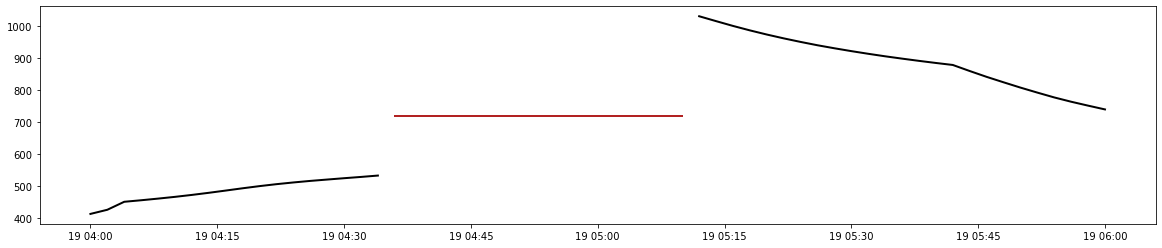

In [6]:
# getting some test data and filtering it to smaller time period
test = data[data["beiwe"] == "kyj367pi"]
test = test[datetime(2020,6,19,4):datetime(2020,6,19,6)]
# getting gap period
gap = pt_gaps["kyj367pi"]["tvoc"]["p0"]
gap.fillna(test["tvoc"].mean(),inplace=True) # mean value imputation'
# plotting
_, ax = plt.subplots(figsize=(20,4))
ax.plot(test.index,test["tvoc"],lw=2,color="black")
ax.plot(gap.index,gap["tvoc"],lw=2,color="firebrick")
plt.show()
plt.close()

<div class="alert-block alert alert-success">
    
The algorithm does seem to correctly identify the gaps in IEQ measurements. 
    
</div>

# Saving Results
Using `pickle` - see this [post](https://stackoverflow.com/questions/57541522/save-load-a-dictionary)

In [7]:
import pickle

In [8]:
def save_gaps(gap_dict):
    with open(f"../data/processed/beacon-ieq_gaps-ux_s20.pickle", 'wb') as f:
        pickle.dump(gap_dict, f, pickle.HIGHEST_PROTOCOL)

In [9]:
save_gaps(pt_gaps)

## Testing that Loading in the File Works

In [10]:
def load_gaps(filename):
    with open(f"../data/processed/{filename}.pickle", 'rb') as f:
        return pickle.load(f)

In [11]:
d = load_gaps("beacon-ieq_gaps-ux_s20")